In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns
import random as rd
import sys

# 1) DENSITY PEAKS

## a) Program from scratch the density peaks algorithm

In [2]:
class DensityPeakCluster:

    def __init__(self,cutoff_distance):

        self.cutoff_distance = cutoff_distance

    def local_density(self):
        
        rho = np.zeros(self.N_points)
        for i in range(self.N_points):
            rho[i]=np.exp(- (self.distances[i, :] /  self.cutoff_distance) ** 2).sum()
        return np.array(rho)

    
    def min_neighbor_and_distance(self):
        
        delta=np.ones(self.N_points) * np.max(self.distances)
        nneigh = np.zeros(self.N_points).astype(int)
        for i in range(self.N_points):
            mask = self.rho<=self.rho[i]
            idx = np.argmin(self.distances[i,:]+mask*np.max(self.distances[i,:]))
            nneigh[i] = idx
            delta[i] = self.distances[i,idx]
            #for j in range(self.n_id):
            #    if self.rho[i]<self.rho[j] and self.distances[i, j] < delta[i]:
            #        delta[i] = self.distances[i,j]
            #        nneigh[i] = j     
        #delta[np.argmax(delta)]=np.sort(delta)[-2]    
        delta[np.argmin(delta)]=np.sort(delta)[-2]
        return np.array(delta), np.array(nneigh)
    
  
    def recursive(self, cluster, i):
        
        if cluster[i] != -1:
            return cluster[i]
        
        return self.recursive( cluster, self.nneigh[i])
            
            
    def collapse(self):

        cluster=dict()
        self.centroid_positions=list()
        cnt=0
        self.density_threshold = (min(self.rho) + max(self.rho))/8
        self.delta_threshold= min( (min(self.delta)+max(self.delta))/8, self.cutoff_distance)
        for idx in range(self.N_points):
            if self.rho[idx] > self.density_threshold and self.delta[idx] > self.delta_threshold:
                cluster[idx] = cnt
                self.centroid_positions.append(self.data[idx])
                cnt=cnt+1
            else:
                cluster[idx] = -1
                
        self.centroid_positions=np.array(self.centroid_positions)
        self.N_centroids = len(self.centroid_positions)

        dist2_mat = cdist(self.data, self.centroid_positions,'sqeuclidean') 
        dist2_min = np.array([np.min(dist2_mat, axis = 1) ]) 
        error = dist2_min.sum() 
        for i in range(self.N_points):
            cluster[i]=self.recursive(cluster, i) 
 
        labels = np.empty(self.N_points).astype(int)
        for k in cluster:
            labels[k] = cluster[k]

        return labels,error 

    def fit(self, data):

        self.data = data
        self.N_points = data.shape[0]
        self.distances=cdist(self.data,self.data ,'euclidean')  
        self.rho = self.local_density()
        self.delta, self.nneigh = self.min_neighbor_and_distance()
        self.labels, self.error = self.collapse()
        return self.labels, self.error
      
    def get_assignation(self):
        out = np.empty((self.N_points,3))
        for idx in range(self.N_points):
            out[idx,0]=self.data[idx][0]
            out[idx,1]=self.data[idx][1]
            out[idx,2]=self.labels[idx]
        return out    
    
    def plot(self):

        colors = plt.cm.get_cmap('rainbow')(np.linspace(0, 1, self.N_centroids))
        
        title_ = "decision graph" 
        fig = plt.figure()
        label_set = set(self.labels)
        label_count = len(label_set)
        for cen in range(self.N_centroids):
            arr_points=self.data[self.labels  == cen]
            plt.scatter(arr_points[:,0],arr_points[:,1], color=colors[cen],s=4)   
        plt.scatter(self.centroid_positions[:,0],self.centroid_positions[:,1], color="k")  
        title_text = 'instance count: %d, label count: %d' % (self.N_points, label_count)
        plt.title(title_text)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.plot()
            
        title_ = "label graph" 
        fig = plt.figure()
        label_set = set(self.labels)
        label_count = len(label_set)
        for cen in range(self.N_centroids):
            delta_points=self.delta[self.labels  == cen]
            rho_points=self.rho[self.labels  == cen]
            plt.scatter(rho_points,delta_points, color=colors[cen],s=4)  
        plt.axhline(y=self.delta_threshold, color='k', linestyle=':') 
        plt.axvline(x=self.density_threshold, color='k', linestyle=':') 
        
        title_text = 'instance count: %d, label count: %d' % (self.N_points, label_count)
        plt.title(title_text)
        plt.xlabel('density')
        plt.ylabel('distance')
        
        
    def F_ratio_index(self):
        SSW=0
        SSB = 0
        n_points_per_centroid=np.empty(self.N_centroids)
        xbar=self.data.mean(axis=0)
        for cen in range(len(self.centroid_positions)):
            centroid_points=self.data[self.labels  == cen]
            n_points_per_centroid[cen] = np.shape(centroid_points)[0]
            c = self.centroid_positions[cen].reshape((1,2))
            d = cdist(centroid_points, c,'sqeuclidean')
            SSW += d.sum()
        
        for cen in range(self.N_centroids):
            a = self.centroid_positions[cen].reshape((1,2))
            b = xbar.reshape((1,2))
            n = n_points_per_centroid[cen]
            
            SSB += n * cdist(a, b  ,'sqeuclidean').sum()
        return self.N_centroids * SSW/SSB

## b) Download the data set Aggregation from http://cs.uef.fi/sipu/datasets/

In [3]:
agg_file = "data/Aggregation.txt"

agg_dataframe_true = pd.read_csv(agg_file,sep="\t", names=["x","y","c"])
agg_dataframe_true = agg_dataframe_true.sort_values(by="c")
agg_dataframe = agg_dataframe_true.drop(columns=["c"])
agg_data=agg_dataframe.values

## c) Apply the algorithm with dc=2.5

error = 14203.045
CPU times: user 113 ms, sys: 10.6 ms, total: 124 ms
Wall time: 125 ms


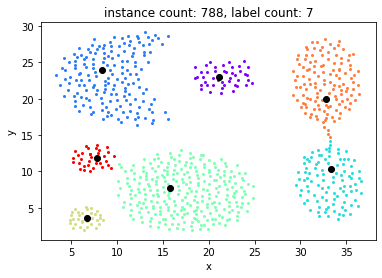

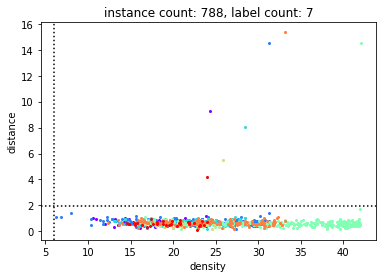

In [4]:
%%time
agg_dpca = DensityPeakCluster(cutoff_distance=2.5)
agg_labels, agg_error = agg_dpca.fit(agg_data)
print("error =",agg_error)  
agg_dpca.plot() 

## d) Apply the algorithm to the S3 data set with dc=57500.

error = 17342774378861.0
CPU times: user 1.04 s, sys: 109 ms, total: 1.15 s
Wall time: 1.27 s


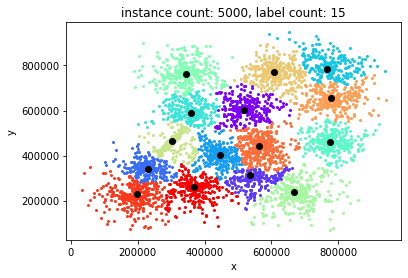

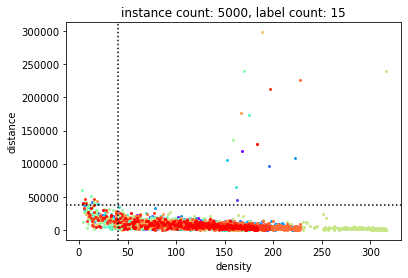

In [5]:
%%time
s3_file_true = "data/s-originals/s3-label.pa"
s3_dataframe_tmp = pd.read_csv(s3_file_true)
s3_dataframe_tmp = s3_dataframe_tmp[4:]
s3_data_true = s3_dataframe_tmp.values

s3_file = "data/s3.txt"
s3_data=np.loadtxt(s3_file)
s3_dataframe_true = pd.DataFrame({'x': s3_data[:, 0], 'y': s3_data[:, 1]})

s3_dpca = DensityPeakCluster(cutoff_distance=57500)
s3_labels, s3_error = s3_dpca.fit(s3_data)
print("error =",s3_error)  
s3_dpca.plot()

# 2) VALIDATION

## a) Apply k-means to the Aggregation data set.

In [6]:
class k_means:

    def __init__(self, N_c):
        
        self.N_centroids = N_c
        
    def initialization_of_centroids_random(self):    
        sel = np.random.choice(self.N_points, size=self.N_centroids, replace=False)
        return self.data[ sel ]
    
    def initialization_of_centroids_plusplus(self):    
        i=rd.randint(0,self.N_points-1)
        centroids=np.array([self.data[i]])
        for k in range(1, self.N_centroids):
            D=np.array([]) 
            D=np.append(D,np.min(cdist(self.data, centroids,'sqeuclidean'), axis=1))
            prob=D/np.sum(D)
            cummulative_prob=np.cumsum(prob)
            r=rd.random()
            i=0
            for j,p in enumerate(cummulative_prob):
                if r<p:
                    i=j
                    break
            centroids=np.append(centroids,[self.data[i]],axis=0)
        return centroids
         
    
    def fit(self, data, init="random", N_max_iterations=1000):
        
        self.data=data
        self.N_points = np.shape(self.data)[0]
        
        if init=="k-means++":
            self.centroid_positions =  self.initialization_of_centroids_plusplus()
        else:    
            self.centroid_positions =  self.initialization_of_centroids_random()
            
        for cnt in range(N_max_iterations):
            dist2_mat = cdist(self.data, self.centroid_positions,'sqeuclidean')   
            dist2_min = np.array([np.min(dist2_mat, axis = 1) ]) 
            self.labels = np.argmin(dist2_mat, axis = 1)
            error = dist2_min.sum() 
            new_centers = np.array([self.data[self.labels  == i].mean(axis=0)
                                for i in range(self.N_centroids) if len(self.data[self.labels  == i]) > 0 ])
            
            if np.shape(self.centroid_positions)!=np.shape(new_centers):
                new_centers = self.initialization_of_centroids_random()
            if np.all(self.centroid_positions == new_centers):
                return error, cnt 
            self.centroid_positions = new_centers
            
        print("Max iterations reached")
        return error,cnt 

       
    def plot(self):    
        
        colors = plt.cm.get_cmap('rainbow')(np.linspace(0, 1, self.N_centroids))
        title_ = "label graph" 
        fig = plt.figure()
        label_set = set(self.labels)
        label_count = len(label_set)
        for cen in range(self.N_centroids):
            arr_points=self.data[self.labels  == cen]
            plt.scatter(arr_points[:,0],arr_points[:,1], color=colors[cen],s=4)
        plt.scatter(self.centroid_positions[:,0],self.centroid_positions[:,1], color="k")   
        title_text = 'instance count: %d, label count: %d' % (self.N_points, label_count)
        plt.title(title_text)
        plt.xlabel('x')
        plt.ylabel('y')
        
    def get_assignation(self):
        out = np.empty((self.N_points,3))
        for idx in range(self.N_points):
            out[idx,0]=self.data[idx][0]
            out[idx,1]=self.data[idx][1]
            out[idx,2]=self.labels[idx]
        return out      
    
    
    def F_ratio_index(self):
        SSW=0
        SSB = 0
        n_points_per_centroid=np.empty(self.N_centroids)
        xbar=self.data.mean(axis=0)
        for cen in range(self.N_centroids):
            centroid_points=self.data[self.labels  == cen]
            n_points_per_centroid[cen] = np.shape(centroid_points)[0]
            c = self.centroid_positions[cen].reshape((1,2))
            SSW += cdist(centroid_points, c, 'sqeuclidean').sum()
        
        for cen in range(self.N_centroids):
            a = self.centroid_positions[cen].reshape((1,2))
            b = xbar.reshape((1,2))
            SSB += n_points_per_centroid[cen] * cdist(a, b  ,'sqeuclidean').sum()
        return self.N_centroids * SSW/SSB    
    

mean = 11806.269857189802
i_min = 10
min = 10996.756054003887
avg convengece = 14.5564


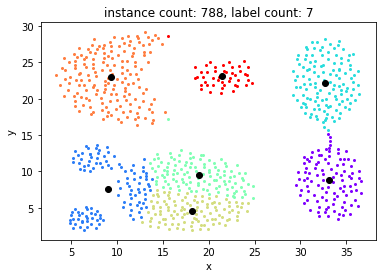

CPU times: user 37.1 s, sys: 798 ms, total: 37.9 s
Wall time: 42.3 s


In [7]:
%%time
N_simulations=5000
agg_tmp_myk = k_means(7)
min_error= sys.maxsize
errors = np.empty(N_simulations)
i_tmp = 0
iterations = np.empty(N_simulations)
for i in range(N_simulations):
    error,iteration=agg_tmp_myk.fit(agg_data) 
    if error<min_error:
        min_error=error
        i_min=i
        agg_myk = agg_tmp_myk
    errors[i]=error
    iterations[i]=iteration
    
agg_myk.plot()
print("mean =",errors.mean())
print("i_min =",i_min)
print("min =",errors[i_min])    
print("avg convengece =",iterations.mean())
plt.show()

## b1) Compare the F-ratio variance test of density peaks and k-means for the Aggregation data set

In [8]:
agg_Fres_dpca=agg_dpca.F_ratio_index()
agg_Fres_kmeans=agg_myk.F_ratio_index()
print("F-ratio variance test of density peaks for Aggregation data set:",agg_Fres_dpca)
print("F-ratio variance test of k-means       for Aggregation data set:",agg_Fres_kmeans)

F-ratio variance test of density peaks for Aggregation data set: 0.8639409727670924
F-ratio variance test of k-means       for Aggregation data set: 0.6794090935626943


## b2) Compare the F-ratio variance test of density peaks and k-means for the  S3 data set

mean =  19566029755447.64
i_min =  258
min =  16889571849356.738
avg convengece =  26.934


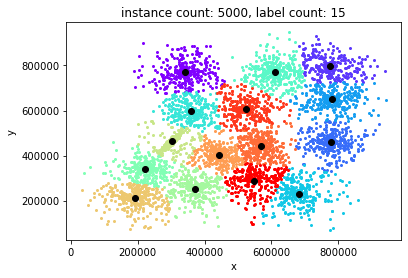

CPU times: user 1min 1s, sys: 1.16 s, total: 1min 2s
Wall time: 1min 9s


In [9]:
%%time
N_simulations=1000
s3_tmp_myk = k_means(15)
min_error= sys.maxsize
errors = np.empty(N_simulations)
i_tmp = 0
iterations = np.empty(N_simulations)
for i in range(N_simulations):
    error,iteration=s3_tmp_myk.fit(data=s3_data) 
    if error<min_error:
        min_error=error
        i_min=i
        s3_myk = s3_tmp_myk
    errors[i]=error
    iterations[i]=iteration
    
s3_myk.plot()
print("mean = ",errors.mean())
print("i_min = ",i_min)
print("min = ",errors[i_min])    
print("avg convengece = ",iterations.mean())
plt.show()

In [10]:
s3_Fres_dpca=s3_dpca.F_ratio_index()
s3_Fres_kmeans=s3_myk.F_ratio_index()
print("F-ratio variance test of density peaks for S3 data set:",s3_Fres_dpca)
print("F-ratio variance test of k-means       for S3 data set:",s3_Fres_kmeans)

F-ratio variance test of density peaks for S3 data set: 0.7640503274998506
F-ratio variance test of k-means       for S3 data set: 0.677003569587815


## c) Compare the Normalized mutual information scores for the two algorithms (k-means and density peaks) and the two data sets (Aggregation and S3).

In [11]:
def normalized_mutual_information(dataset_final):

    n_tot=np.shape(dataset_final)[0]
    prob_my=dataset_final[["x","my_c"]].groupby(["my_c"]).agg(p_my=('my_c',pd.Series.count)).reset_index()
    prob_my=prob_my["p_my"]/n_tot
    pm=prob_my.values
    n_tot=np.shape(dataset_final)[0]
    prob_true=dataset_final[["x","c"]].groupby(["c"]).agg(p_t=('c',pd.Series.count)).reset_index()
    prob_true=prob_true["p_t"]/n_tot
    pt=prob_true.values
    p_ij=np.zeros((np.shape(prob_true.values)[0],np.shape(prob_true.values)[0])).astype(int)
    n_tot=np.shape(dataset_final)[0]
    mat=dataset_final.groupby(["my_c","c"]).agg(n=("x",pd.Series.count)).reset_index().to_numpy()
    for i in range(mat.shape[0]):
        p_ij[mat[i][0],mat[i][1]-1] = mat[i][2]
    p_ij=p_ij/n_tot
    MI=0
    for i in range(np.shape(prob_true.values)[0]):
        for j in range(np.shape(prob_true.values)[0]):
            if p_ij[i,j]!=0.:
                MI += p_ij[i,j]*np.log(p_ij[i,j]/(pm[i]*pt[j]))
            
    H_m = - (pm * np.log(pm)).sum() 
    H_t = - (pt * np.log(pt)).sum() 

    NMI=2*MI/(H_m+H_t)
    return NMI

### Aggregation data set

In [12]:
agg_file = "data/Aggregation.txt"

agg_dataframe_true = pd.read_csv(agg_file,sep="\t", names=["x","y","c"])
agg_dataframe_true = agg_dataframe_true.sort_values(by="c")
agg_dataframe = agg_dataframe_true.drop(columns=["c"])
agg_data=agg_dataframe.values

agg_dpca_res=agg_dpca.get_assignation()

agg_dpca_dataset_my = pd.DataFrame({'x': agg_dpca_res[:, 0], 'y': agg_dpca_res[:, 1], 'my_c': agg_dpca_res[:, 2]})
agg_dpca_dataset_my["my_c"]=agg_dpca_dataset_my["my_c"].astype(int)
agg_dpca_dataset_final=agg_dpca_dataset_my.merge(agg_dataframe_true, on=['x','y'], how='left')


In [13]:
agg_file = "data/Aggregation.txt"

agg_dataframe_true = pd.read_csv(agg_file,sep="\t", names=["x","y","c"])
agg_dataframe_true = agg_dataframe_true.sort_values(by="c")
agg_dataframe = agg_dataframe_true.drop(columns=["c"])
agg_data=agg_dataframe.values

agg_myk_res=agg_myk.get_assignation()

agg_myk_dataset_my = pd.DataFrame({'x': agg_myk_res[:, 0], 'y': agg_myk_res[:, 1], 'my_c': agg_myk_res[:, 2]})
agg_myk_dataset_my["my_c"]=agg_myk_dataset_my["my_c"].astype(int)
agg_myk_dataset_final=agg_myk_dataset_my.merge(agg_dataframe_true, on=['x','y'], how='left')


In [14]:
print("Normalized Mutual Information for density peak =", normalized_mutual_information(agg_dpca_dataset_final))
print("Normalized Mutual Information for k-means      =", normalized_mutual_information(agg_myk_dataset_final))


Normalized Mutual Information for density peak = 1.0
Normalized Mutual Information for k-means      = 0.8410214174409372


### S3 data set

In [15]:
s3_file_true = "data/s-originals/s3-label.pa"
s3_dataframe_tmp = pd.read_csv(s3_file_true)
s3_dataframe_tmp = s3_dataframe_tmp[4:]
s3_data_true = s3_dataframe_tmp.values
s3_file = "data/s3.txt"
s3_data=np.loadtxt(s3_file)
s3_dataframe_true = pd.DataFrame({'x': s3_data[:, 0], 'y': s3_data[:, 1]})

s3_dpca_res=s3_dpca.get_assignation()

s3_dpca_dataset_my = pd.DataFrame({'x': s3_dpca_res[:, 0], 'y': s3_dpca_res[:, 1], 'my_c': s3_dpca_res[:, 2]})
s3_dpca_dataset_my["my_c"]=s3_dpca_dataset_my["my_c"].astype(int)
s3_dataframe_true["c"]=s3_data_true
s3_dataframe_true["c"]=s3_dataframe_true["c"].astype(int)
s3_dataframe_true = s3_dataframe_true.sort_values(by="c")
s3_dataframe_true = s3_dataframe_true.reset_index(drop=True)
s3_dpca_dataset_final=s3_dpca_dataset_my.merge(s3_dataframe_true, on=['x','y'], how='left')


In [16]:
s3_file_true = "data/s-originals/s3-label.pa"
s3_dataframe_tmp = pd.read_csv(s3_file_true)
s3_dataframe_tmp = s3_dataframe_tmp[4:]
s3_data_true = s3_dataframe_tmp.values
s3_file = "data/s3.txt"
s3_data=np.loadtxt(s3_file)
s3_dataframe_true = pd.DataFrame({'x': s3_data[:, 0], 'y': s3_data[:, 1]})

s3_myk_res=s3_myk.get_assignation()

s3_myk_dataset_my = pd.DataFrame({'x': s3_myk_res[:, 0], 'y': s3_myk_res[:, 1], 'my_c': s3_myk_res[:, 2]})
s3_myk_dataset_my["my_c"]=s3_myk_dataset_my["my_c"].astype(int)
s3_dataframe_true["c"]=s3_data_true
s3_dataframe_true["c"]=s3_dataframe_true["c"].astype(int)
s3_dataframe_true = s3_dataframe_true.sort_values(by="c")
s3_dataframe_true = s3_dataframe_true.reset_index(drop=True)
s3_myk_dataset_final=s3_myk_dataset_my.merge(s3_dataframe_true, on=['x','y'], how='left')


In [17]:
print("Normalized Mutual Information for density peak =", normalized_mutual_information(s3_dpca_dataset_final))
print("Normalized Mutual Information for k-means      =", normalized_mutual_information(s3_myk_dataset_final))


Normalized Mutual Information for density peak = 0.7854416149830893
Normalized Mutual Information for k-means      = 0.7964715215736309
